In [2]:
from google.colab import drive
drive.mount("/content/drive")

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

# Load data

In [4]:
df_trans = pd.read_csv("/content/drive/MyDrive/kkbox-churn/transactions.csv")
df_trans2 = pd.read_csv("/content/drive/MyDrive/kkbox-churn/transactions_v2.csv")

In [5]:
df_trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [6]:
df_trans2.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


# Data preprocessing

In [5]:
df_trans["transaction_date"] = pd.to_datetime(df_trans["transaction_date"], format="%Y%m%d")
df_trans["membership_expire_date"] = pd.to_datetime(df_trans["membership_expire_date"], format="%Y%m%d")

df_trans2["transaction_date"] = pd.to_datetime(df_trans2["transaction_date"], format="%Y%m%d")
df_trans2["membership_expire_date"] = pd.to_datetime(df_trans2["membership_expire_date"], format="%Y%m%d")

In [6]:
df_trans = pd.concat([df_trans, df_trans2])
df_trans.shape

(22978755, 9)

In [7]:
del df_trans2

In [8]:
df_trans = df_trans.sort_values(by=["msno", "transaction_date", "membership_expire_date"])
df_trans = df_trans.reset_index(drop=True)

In [9]:
df_trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,0,2016-09-09,2016-09-14,0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788,1788,0,2015-11-21,2017-01-04,0
2,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,2016-10-23,2018-02-06,0
3,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,2016-11-16,2016-12-15,0
4,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,2016-12-15,2017-01-15,0


# Label engineering

In [17]:
# grace_period = 10
# labels = []

# # for i, row in tqdm(df_trans.iterrows(), total=df_trans.shape[0]):
# #     msno = row["msno"]
# #     expire_date = row["membership_expire_date"]
# #     if (row["payment_plan_days"] >= 28) and (row["payment_plan_days"] <= 32) and (row["is_cancel"] == 0):
# #         future_trans = df_trans[
# #             (df_trans["msno"] == msno) &
# #             (df_trans["is_cancel"] == 0) &
# #             (df_trans["transaction_date"] <= expire_date + pd.Timedelta(days=grace_period))
# #         ]
# #         if not future_trans.empty:
# #             labels.append(0)
# #         else:
# #             labels.append(1)

# for i in tqdm(range(len(df_trans))):
#     row = df_trans.iloc[i]
#     msno = row["msno"]
#     expire_date = row["membership_expire_date"]

#     if 30 <= row["payment_plan_days"] <= 31 and row["is_cancel"] == 0:
#         found_future_txn = False

#         # Look ahead in the DataFrame (no new DF creation)
#         for j in range(i + 1, len(df_trans)):
#             next_row = df_trans.iloc[j]

#             # Early break if we go beyond grace period or different user
#             if next_row["msno"] != msno:
#                 if found_future_txn:  # safety
#                     break
#                 continue

#             if next_row["transaction_date"] > expire_date + pd.Timedelta(days=grace_period):
#                 break

#             if next_row["is_cancel"] == 0:
#                 found_future_txn = True
#                 break

#         labels.append(0 if found_future_txn else 1)

In [18]:
grace_period = pd.Timedelta(days=10)
labels = []

grouped = df_trans.groupby("msno", sort=False)

for msno, group in tqdm(grouped, total=len(grouped)):
    group = group.reset_index(drop=True)
    label = []

    for i in range(len(group)):
        row = group.iloc[i]
        expire_date = row["membership_expire_date"]

        if 30 <= row["payment_plan_days"] <= 31 and row["is_cancel"] == 0:
            found = False

            for j in range(i + 1, len(group)):
                next_row = group.iloc[j]

                if next_row["transaction_date"] > expire_date + grace_period:
                    break

                if next_row["transaction_date"] <= expire_date + grace_period and next_row["is_cancel"] == 0:
                    found = True
                    break

            label.append(0 if found else 1)

    labels.extend(label)

100%|██████████| 2426143/2426143 [1:22:09<00:00, 492.20it/s]


In [34]:
len(labels)

20067123

In [38]:
print(f"Proportion of 0s: {labels.count(0) / len(labels):.2f}")
print(f"Proportion of 1s: {labels.count(1) / len(labels):.2f}")

Proportion of 0s: 0.88
Proportion of 1s: 0.12


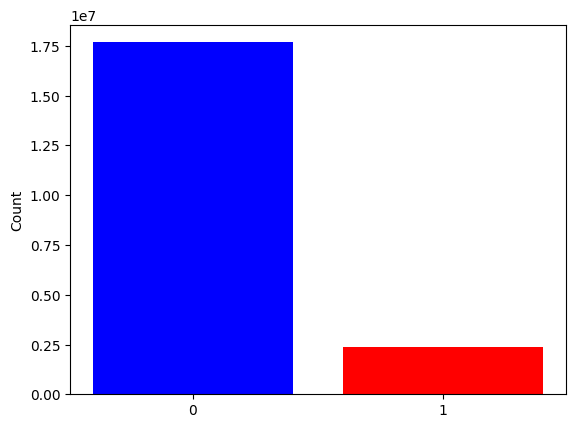

In [20]:
plt.bar([0, 1], [labels.count(0), labels.count(1)], color=['blue', 'red'])
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()

In [29]:
with open("/content/drive/MyDrive/kkbox-churn/labels.pkl", "wb") as f:
    pickle.dump(labels, f)

# Merge labels with transactions table

In [11]:
with open("/content/drive/MyDrive/kkbox-churn/labels.pkl", "rb") as f:
    labels = pickle.load(f)

In [12]:
df_labeled = df_trans[(df_trans["payment_plan_days"].between(30, 31)) & (df_trans["is_cancel"] == 0)].copy()

df_labeled["churn"] = labels
df_labeled["membership_start_date"] = df_labeled["membership_expire_date"] - pd.to_timedelta(df_labeled["payment_plan_days"], unit="D")

final_df = df_labeled[[
    "msno",
    "membership_start_date",
    "membership_expire_date",
    "payment_method_id",
    "plan_list_price",
    "actual_amount_paid",
    "is_auto_renew",
    "transaction_date",
    "churn"
]]

In [13]:
final_df.head()

,msno,membership_start_date,membership_expire_date,payment_method_id,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,churn
3,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2016-11-15,2016-12-15,41,99,99,1,2016-11-16,0
4,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2016-12-16,2017-01-15,41,99,99,1,2016-12-15,0
5,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-01-16,2017-02-15,41,99,99,1,2017-01-15,0
6,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-13,2017-03-15,41,99,99,1,2017-02-15,0
7,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-03-16,2017-04-15,41,99,99,1,2017-03-15,1


In [ ]:
final_df.to_csv("/content/drive/MyDrive/kkbox-churn/labeled_transactions.csv", index=False)